<a href="https://colab.research.google.com/github/Sohaib9920/Transformer_Text_Classification/blob/main/Transformer_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

# Loading Data

In [5]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
train_ds = emotions["train"]
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}



---


Or If data is available remote or locally then:

In [16]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2024-01-24 17:14:09--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 65.8.243.16, 65.8.243.92, 65.8.243.90, ...
Connecting to huggingface.co (huggingface.co)|65.8.243.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt.2’

train.txt.2         100%[===================>]   1.58M  7.03MB/s    in 0.2s    

2024-01-24 17:14:09 (7.03 MB/s) - ‘train.txt.2’ saved [1658616/1658616]



In [17]:
!head "train.txt"

i didnt feel humiliated;sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness
im grabbing a minute to post i feel greedy wrong;anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love
i am feeling grouchy;anger
ive been feeling a little burdened lately wasnt sure why that was;sadness
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise
i feel as confused about life as a teenager or as jaded as a year old man;fear
i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy
i feel romantic too;love


In [33]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=",", names=["text", "label"])

In [34]:
emotions_local

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

OR

In [31]:
emotions_local = load_dataset("csv", data_files=dataset_url, sep=",", names=["text", "label"], split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

Generating train split: 0 examples [00:00, ? examples/s]

In [32]:
emotions_local

[Dataset({
     features: ['text', 'label'],
     num_rows: 12800
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1600
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1600
 })]



---



# Visualizing the data

In [35]:
emotions.set_format(type="pandas") # Only change the output fromat and not the underlying data format (Arrow Table)
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [38]:
class_labels = emotions["train"].features["label"]
class_labels

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [39]:
df["label_name"] = df["label"].apply(lambda x: class_labels.int2str(x))
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


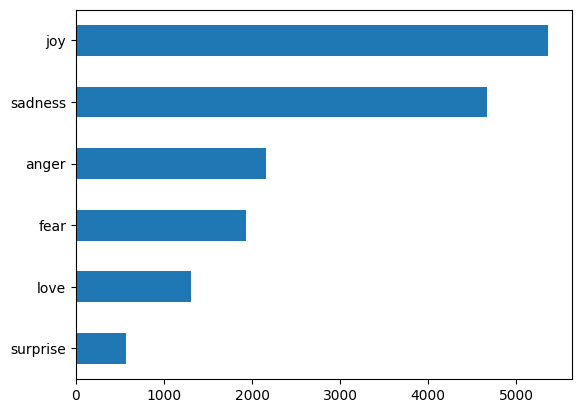

In [43]:
df["label_name"].value_counts(ascending=True).plot.barh();

Transformer models have a maximum input sequence length that is referred to as the
maximum context size. **For applications using DistilBERT, the maximum context size is 512 tokens**. Lets get an estimate of how long are our tweets

In [57]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


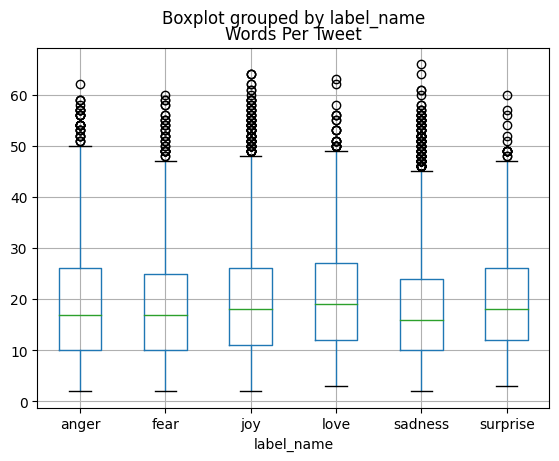

In [60]:
df.boxplot("Words Per Tweet", by="label_name");

Maximum words per tweet are less than the maximum context size of 512. Most of the tweets are about 15 words longs, for all emotions.

In [70]:
emotions.reset_format()

# Tokenization

In [84]:
from transformers import AutoTokenizer

In [86]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [87]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [113]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [115]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [116]:
tokenizer.convert_tokens_to_string(tokens) # similar to " ".join() but handle sub-word tokenization artifacts

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [119]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

Tokenizing whole dataset:

In [137]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [140]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

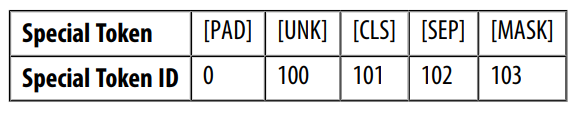

In [148]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

By default, the `map()` method operates individually on every example in the corpus,
so setting `batched=True` will encode the tweets in batches. Because we’ve set
`batch_size=None`, our `tokenize()` function will be applied on the full dataset as a
single batch. This ensures that the input tensors and attention masks have the same
shape globally

In [150]:
emotions_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

In [160]:
import pandas as pd
pd.DataFrame(emotions_encoded["train"][:5])

,text,label,input_ids,attention_mask
0,i didnt feel humiliated,0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i can go from feeling so hopeless to so damned...,0,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,im grabbing a minute to post i feel greedy wrong,3,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,i am ever feeling nostalgic about the fireplac...,2,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i am feeling grouchy,3,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


# Training a Text Classifier

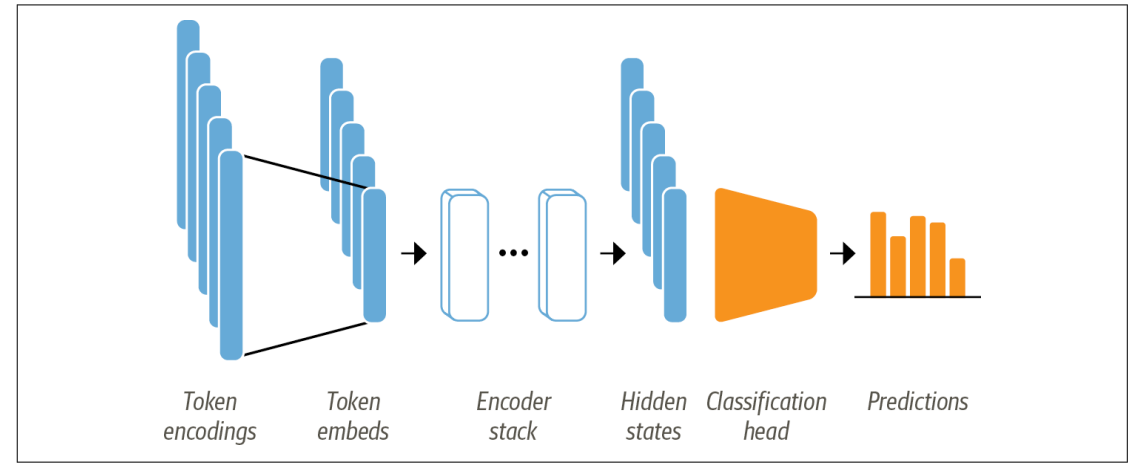